In [1]:
# %load imports.py
## Local packages:

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
np.set_printoptions(linewidth=150)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl

from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.regression import show_pred
from src.visualization.plot import track_plot

## Load models:
# (Uncomment these for faster loading):
import src.models.vmm_martin  as vmm 
from src.models.vmm import ModelSimulator
from example_ship2 import ship_parameters, df_parameters


if os.name == 'nt':
    plt.style.use('../docs/book/book.mplstyle')  # Windows
    
from src.visualization.plot import track_plot, plot

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')
C:\Dev\wPCC\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from src.extended_kalman_vmm import ExtendedKalman

## Load test

In [3]:
id=22773
df, units, meta_data = mdl.load(dir_path = '../data/raw', id=id)
df.index = df.index.total_seconds()
df.index-=df.index[0]
df['x0']-=df.iloc[0]['x0']
df['y0']-=df.iloc[0]['y0']
df['psi']-=df.iloc[0]['psi']


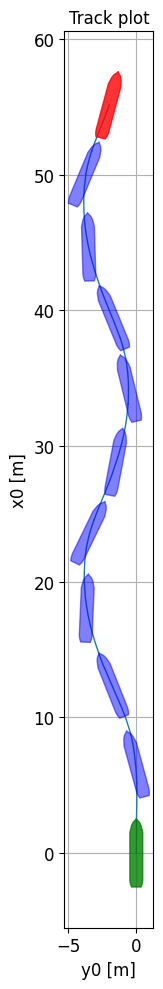

In [4]:
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

## Filtering

### Lowpass filter

In [5]:
from numpy import cos as cos
from numpy import sin as sin
from src.data.lowpass_filter import lowpass_filter

df_lowpass = df.copy()
t = df_lowpass.index
ts = np.mean(np.diff(t))
fs = 1/ts

position_keys = ['x0','y0','psi']
for key in position_keys:
    df_lowpass[key] = lowpass_filter(data=df_lowpass[key], fs=fs, cutoff=1, order=1)

df_lowpass['x01d_gradient'] = x1d_ = np.gradient(df_lowpass['x0'], t)
df_lowpass['y01d_gradient'] = y1d_ = np.gradient(df_lowpass['y0'], t)
df_lowpass['r'] = r_ = np.gradient(df_lowpass['psi'], t)

psi_ = df_lowpass['psi']

df_lowpass['u'] = x1d_*cos(psi_) + y1d_*sin(psi_)
df_lowpass['v'] = -x1d_*sin(psi_) + y1d_*cos(psi_)

velocity_keys = ['u','v','r']
for key in velocity_keys:
    df_lowpass[key] = lowpass_filter(data=df_lowpass[key], fs=fs, cutoff=1, order=1)

In [6]:
data = df.copy()
data['thrust'] = data['Prop/PS/Thrust'] + data['Prop/SB/Thrust']

data['u'] = df_lowpass['u']
data['v'] = df_lowpass['v']
data['r'] = df_lowpass['r']
data=data.iloc[200:-100]
data.index-=data.index[0]

### Extended Kalman filter

In [7]:
parameters = df_parameters["prime"].copy()
ek = ExtendedKalman(vmm=vmm, 
                    parameters=parameters, 
                    ship_parameters=ship_parameters)


#### Simulate with system model

In [8]:
E = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    ],
)

t = np.linspace(0,10,100)
data_ = pd.DataFrame(index=t)
data_['delta'] = 0.0
data_['thrust'] = 20
data_['x0'] = 0
data_['y0'] = 0
data_['psi'] = 0
data_['u'] = 2
data_['v'] = 0
data_['r'] = 0

ek.parameters = parameters = df_parameters["prime"].copy()
ek.simulate(data=data,input_columns=['delta','thrust'], 
            E=E).tail()

,x0,y0,psi,u,v,r,delta,thrust
time,,,,,,,,
66.780008,45.119343,-13.763298,-0.016567,0.654657,-0.038204,-0.003261,0.349072,12.687978
66.789998,45.125885,-13.763789,-0.016599,0.654582,-0.038084,-0.003334,0.349065,12.925806
66.799999,45.132425,-13.764279,-0.016633,0.654513,-0.037964,-0.003406,0.349065,13.133883
66.810001,45.138965,-13.764767,-0.016667,0.654446,-0.037845,-0.003479,0.349078,13.252854
66.820027,45.145504,-13.765255,-0.016702,0.654380,-0.037725,-0.003551,0.349065,13.243134


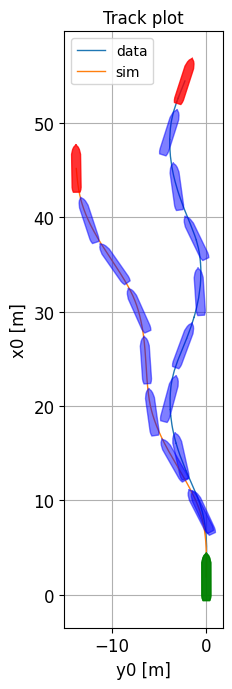

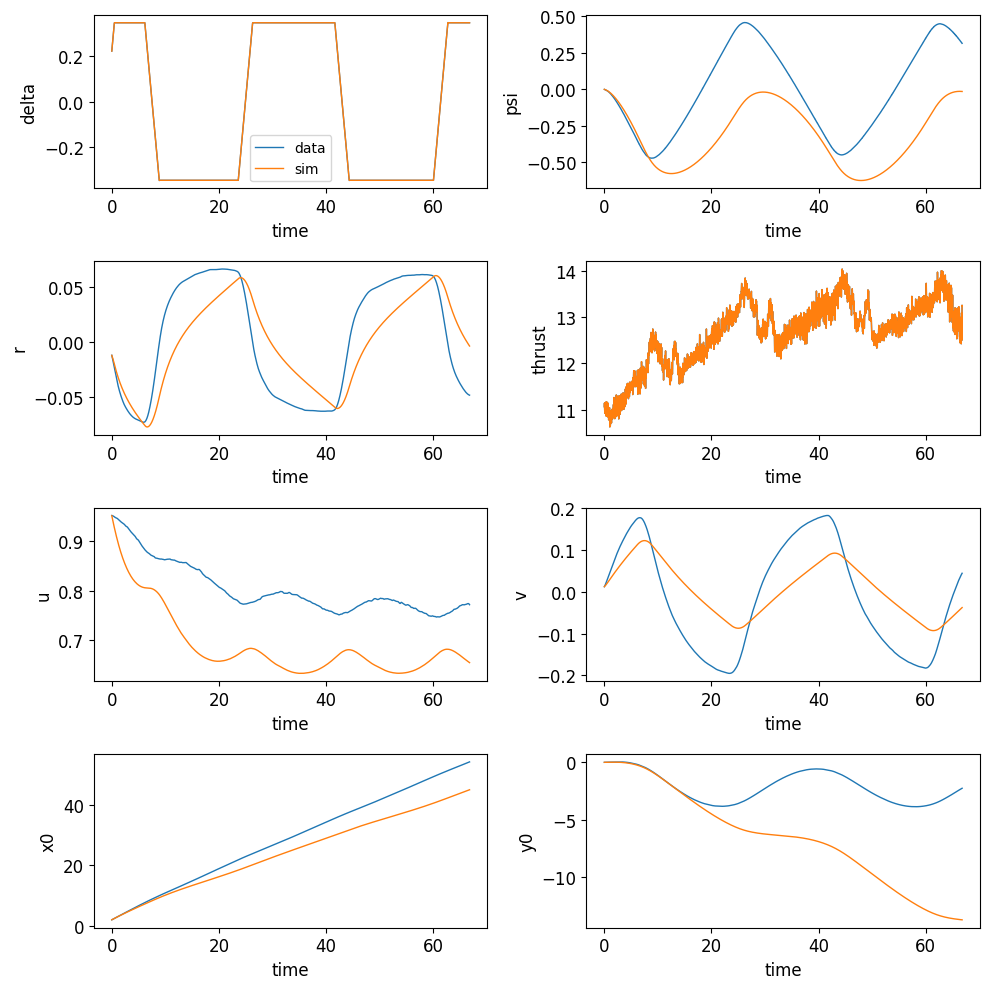

In [9]:
data_frames = {'data':data, 'sim':ek.df_simulation}

fig,ax=plt.subplots()
styles = {
    'Mesurement' : {
        'linestyle' : '',
        'marker' : '.',
        'ms' : 1,
        'zorder':-10,
    },
    
    'Kalman filter' : {
        'lw' : 2,
    },
    
    
}

for label,df_ in data_frames.items():
    track_plot(
            df=df_,
            lpp=ship_parameters["L"],
            beam=ship_parameters["B"],
            ax=ax,
            label=label,
            plot_boats=True,
            **styles.get(label,{})
        );
ax.legend()

plot(data_frames, keys=ek.df_simulation.columns);

### Extended Kalman filter and RTS smoother

In [10]:
Cd = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
])

E = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    ],
)

P_prd = np.diag([0.1, 0.1, np.deg2rad(0.01), 0.01, 0.01, np.deg2rad(0.01)])
Qd = np.diag([0.001, 0.001, np.deg2rad(0.001)])  #process variances: u,v,r

error_max_pos = 0.1
sigma_pos = error_max_pos/3
variance_pos = sigma_pos**2

error_max_psi = np.deg2rad(2)
sigma_psi = error_max_psi/3
variance_psi = sigma_psi**2

Rd = np.diag([variance_pos, variance_pos, variance_psi])

ek.filter(
        data=data, P_prd=P_prd, Qd=Qd, Rd=Rd, E=E, Cd=Cd, 
        input_columns=['delta','thrust'],
    )
ek.smoother();

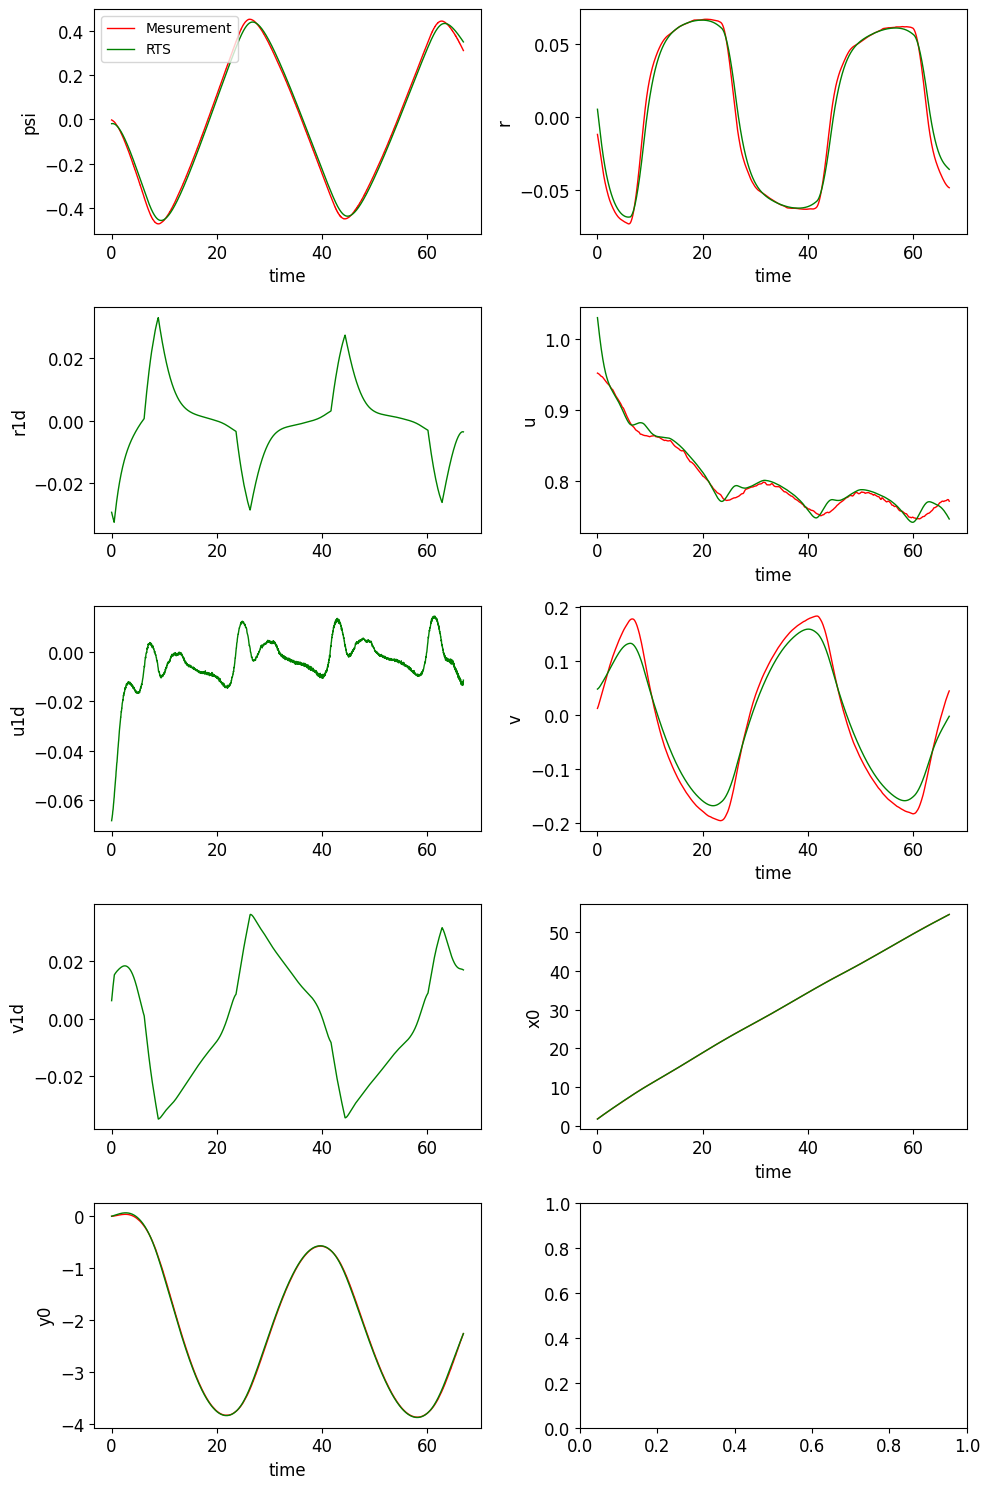

In [11]:
dataframes = {
    'Mesurement' : data,
    #'Kalman filter' : ek.df_kalman,
    'RTS': ek.df_smooth,
}

styles = {
    'Mesurement' : {
        'linestyle' : '',
        'marker' : '.',
        'ms' : 1,
        'zorder':-10,
    },
    
    'Kalman filter' : {
        'lw' : 2,
    },
    
    
}

plot(dataframes = dataframes, 
     fig_size=(10,15), 
     styles = ['r-','g-','b-'],
     keys=['x0','y0','psi','u','v','r','u1d','v1d','r1d']);